Most of these idea and code are refered from: https://github.com/hlk-1135/object-CXR and https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [3]:
import pandas as pd
from PIL import Image, ImageDraw
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from shapely.geometry import LineString
from shapely.algorithms.polylabel import polylabel
from shapely.ops import unary_union
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as transforms
import torch
import os
import utils
from engine import train_one_epoch
from sklearn.metrics import roc_auc_score, roc_curve, auc


Visualzing the original dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


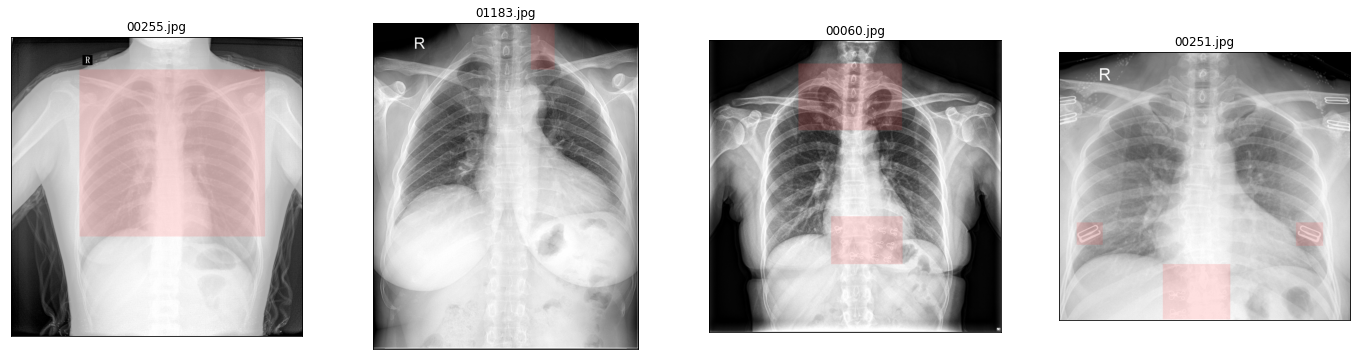

In [4]:
from google.colab import drive
drive.mount('/content/drive')

boxes = []
split = 'dev'

OBJECT_SEP = ';'
ANNOTATION_SEP = ' '
# Each data is separated by <space>, each of bounding box is separated by ;
# First data is to defining shape of bbox, last 4 is the position
def draw_annotation(im, anno_str, fill=(255, 63, 63, 40)):
    draw = ImageDraw.Draw(im, mode="RGBA")
    for anno in anno_str.split(OBJECT_SEP):
        anno = list(map(int, anno.split(ANNOTATION_SEP)))
        if anno[0] == 0:
            draw.rectangle(anno[1:], fill=fill)
        elif anno[0] == 1:
            draw.ellipse(anno[1:], fill=fill)
        else:
            draw.polygon(anno[1:], fill=fill)
            draw.polygon(anno[1:],fill = fill)
data_dir = 'drive/MyDrive/object-cxr/'
label_train = pd.read_csv(data_dir+'train.csv', na_filter = False)
label_dev = pd.read_csv(data_dir+'dev.csv', na_filter = False)

label_train = label_train.loc[label_train['annotation'].astype(bool)].reset_index(drop=True)
img_class_dict_tr = dict(zip(label_train.image_name, label_train.annotation))
img_class_dict_dev = dict(zip(label_dev.image_name, label_dev.annotation))
fig, axs = plt.subplots(nrows=1, ncols=4, subplot_kw=dict(xticks=[], yticks=[]),
                        figsize=(24, 6))

example_idxes = [127,567,34,123]
for row, ax in zip(label_train.iloc[example_idxes].itertuples(index=False), axs):
    im = Image.open(data_dir + "train/" + row.image_name).convert("RGB")
    if row.annotation:
        draw_annotation(im, row.annotation)
    
    ax.imshow(im)
    ax.set_title(f"{row.image_name}")


This class is used for defining dataset for foreign object

In [5]:
class ForeignObjectDataset(object):
    
    def __init__(self, datafolder, datatype='train', transform = True, labels_dict={}):
        self.datafolder = datafolder
        self.datatype = datatype
        self.labels_dict = labels_dict
        # load all image files, sorting them to
        # ensure that they are aligned
        self.image_files_list = [s for s in sorted(os.listdir(datafolder)) if s in labels_dict.keys()]
        self.transform = transform
        self.annotations = [labels_dict[i] for i in self.image_files_list]
            
    def __getitem__(self, idx):
        # load images 
        img_name = self.image_files_list[idx]
        img_path = os.path.join(self.datafolder, img_name)
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        img = Image.open(img_path).convert("RGB")
        width, height = img.size[0],img.size[1]  
        
        if self.datatype == 'train':
            annotation = self.labels_dict[img_name]
            
            boxes = []
        
            # take the information about the bounding box and append it to list of boxes
            if type(annotation) == str:
                annotation_list = annotation.split(';')
                for anno in annotation_list:
                    x = []
                    y = []
                
                    anno = anno[2:]
                    anno = anno.split(' ')
                    for i in range(len(anno)):
                        if i % 2 == 0:
                            x.append(float(anno[i]))
                        else:
                            y.append(float(anno[i]))
                        
                    xmin = min(x)/width * 600
                    xmax = max(x)/width * 600
                    ymin = min(y)/height * 600
                    ymax = max(y)/height * 600
                    boxes.append([xmin, ymin, xmax, ymax])

            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((len(boxes),), dtype=torch.int64)

            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            # suppose all instances are not crowd
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd
            
            if self.transform is not None:
                img = self.transform(img)
                
            return img, target
        
        if self.datatype == 'dev':
            
            if self.labels_dict[img_name] == '':
                label = 0
            else:
                label = 1
            
            if self.transform is not None:
                img = self.transform(img)

            return img, label, width, height

        

    def __len__(self):
        return len(self.image_files_list)

Perform the training and validating

In [6]:
def _get_detection_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    data_transforms = transforms.Compose([
    transforms.Resize((600,600)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset_train = ForeignObjectDataset(datafolder= data_dir + 'train/',
                                         datatype='train', transform=data_transforms,
                                         labels_dict=img_class_dict_tr)
    dataset_dev = ForeignObjectDataset(datafolder= data_dir + 'dev/', datatype='dev',
                                       transform=data_transforms,
                                       labels_dict=img_class_dict_dev)



    

    num_classes = 2# 1 class odd object + background (human body)
    # set up the data and the option for the training
    data_loader = torch.utils.data.DataLoader(
                  dataset_train, batch_size=4, shuffle= True, num_workers=4,
                  collate_fn=utils.collate_fn)
    
    data_loader_val = torch.utils.data.DataLoader(
        dataset_dev, batch_size=1, shuffle= False, num_workers=4,
        collate_fn=utils.collate_fn)
    
    # get the model using our helper function
    model_ft = _get_detection_model(num_classes)
    # move model to the right device
    model_ft.to(device)
    
    # construct an optimizer
    params = [p for p in model_ft.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    # and a learning rate scheduler which decreases the learning rate by
    # 10x every 2 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=2,
                                                   gamma=0.1)

    num_epochs = 6

    auc_max = 0

    for epoch in range(num_epochs):
        # train for one epoch, printing every 100 iterations
        train_one_epoch(model_ft, optimizer, data_loader, device, epoch, print_freq=100)
        
        # update the learning rate
        lr_scheduler.step()
        
        model_ft.eval()
        val_pred = []
        val_label = []
        
        # Evaluating each epoch
        for batch_i, (image, label,  width, height) in enumerate(data_loader_val):
            image = list(img.to(device) for img in image)
            
            val_label.append(label[-1])

            outputs = model_ft(image)
            if len(outputs[-1]['boxes']) == 0:
                val_pred.append(0)
            else:
                val_pred.append(torch.max(outputs[-1]['scores']).tolist())
        
        val_pred_label = []
        for i in range(len(val_pred)):
            if val_pred[i] >= 0.5:
                val_pred_label.append(1)
            else:
                val_pred_label.append(0)
                
        number = 0
        
        for i in range(len(val_pred_label)):
            if val_pred_label[i] == val_label[i]:
                number += 1
        acc = number / len(val_pred_label)
        auc = roc_auc_score(val_label,val_pred)
        print('Epoch: ', epoch, '| val acc: %.4f' % acc, '| val auc: %.4f' % auc)
        
        if auc > auc_max:
            auc_max = auc
            print('Best Epoch: ', epoch, '| val acc: %.4f' % acc, '| Best val auc: %.4f' % auc_max)
            torch.save(model_ft.state_dict(), "drive/MyDrive/object-cxr/model.pt")

In [14]:
main()

Epoch: [0]  [   0/1000]  eta: 0:53:02  lr: 0.000010  loss: 2.0629 (2.0629)  loss_classifier: 1.4863 (1.4863)  loss_box_reg: 0.0032 (0.0032)  loss_objectness: 0.5547 (0.5547)  loss_rpn_box_reg: 0.0187 (0.0187)  time: 3.1821
Epoch: [0]  [ 100/1000]  eta: 0:13:25  lr: 0.000510  loss: 0.2433 (0.4255)  loss_classifier: 0.0995 (0.2050)  loss_box_reg: 0.0698 (0.0711)  loss_objectness: 0.0679 (0.1349)  loss_rpn_box_reg: 0.0099 (0.0146)  time: 0.8535
Epoch: [0]  [ 200/1000]  eta: 0:11:50  lr: 0.001010  loss: 0.3350 (0.3834)  loss_classifier: 0.1370 (0.1720)  loss_box_reg: 0.1121 (0.0951)  loss_objectness: 0.0673 (0.1031)  loss_rpn_box_reg: 0.0117 (0.0131)  time: 0.8542
Epoch: [0]  [ 300/1000]  eta: 0:10:16  lr: 0.001510  loss: 0.4312 (0.3836)  loss_classifier: 0.1503 (0.1637)  loss_box_reg: 0.1817 (0.1131)  loss_objectness: 0.0514 (0.0936)  loss_rpn_box_reg: 0.0121 (0.0132)  time: 0.8725
Epoch: [0]  [ 400/1000]  eta: 0:08:46  lr: 0.002010  loss: 0.3543 (0.3798)  loss_classifier: 0.1446 (0.1597)

This part is used for applying and testing the model

In [36]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = _get_detection_model(2)
model.to(device)

# get the trained model 
model.load_state_dict(torch.load("drive/MyDrive/object-cxr/model.pt"))
# put the model in evaluation mode
model.eval()
data_transforms = transforms.Compose([
    transforms.Resize((600,600)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
# define the dataset use for test
dataset_dev = ForeignObjectDataset(datafolder= data_dir + 'dev/', datatype='dev',
                                       transform=data_transforms,
                                       labels_dict=img_class_dict_dev)
# define the test data loaders
data_loader_val = torch.utils.data.DataLoader(
    dataset_dev, batch_size=1, shuffle= False, num_workers=4,
    collate_fn=utils.collate_fn)

preds = []
labels = []
locs = []

# iterable-style dataset
from tqdm import tqdm
for image, label, width, height in data_loader_val:
    
    image = list(img.to(device) for img in image)
    labels.append(label[-1])
    
    outputs = model(image)
    
    center_points = []
    center_points_preds = []
    bbox = []
    
    if len(outputs[-1]['boxes']) == 0:
        preds.append(0)
        center_points.append([])
        center_points_preds.append('')
        bbox.append('')
        locs.append('')
    else:
        preds.append(torch.max(outputs[-1]['scores']).tolist())
        
        new_output_index = torch.where((outputs[-1]['scores']>0.1))
        new_boxes = outputs[-1]['boxes'][new_output_index]
        new_scores = outputs[-1]['scores'][new_output_index]
        line = ''
        center_points_preds += new_scores.tolist()
        for i in range(len(new_boxes)):
            new_box = new_boxes[i].tolist()
            center_x = (new_box[0] + new_box[2])/2
            center_y = (new_box[1] + new_box[3])/2
            center_points.append([center_x/600 * width[-1],center_y/600 * height[-1]])
            bbox.append([new_box[0]/600 * width[-1], new_box[2]/600 * width[-1], new_box[1]/600 * height[-1] ,new_box[3]/600 * height[-1] ])
            if i == len(new_boxes)-1:
                line += str(center_points_preds[i]) + " " + str(center_points[i][0]) + ' ' + str(center_points[i][1]) + ' ' + str(bbox[i][0]) + ' ' + str(bbox[i][1]) + ' '+ str(bbox[i][2]) + ' ' + str(bbox[i][3])
            else:
                line += str(center_points_preds[i]) + " " + str(center_points[i][0]) + ' ' + str(center_points[i][1]) + ' ' + str(bbox[i][0]) + ' ' + str(bbox[i][1]) + ' ' + str(bbox[i][2]) + ' ' + str(bbox[i][3]) +';'
        locs.append(line)
        

# save the result to the excel file

# predicted probability, ranging from 0 to 1, 0 for no object, the higher score the more guarantee has object, maximum is 1
cls_res = pd.DataFrame({'image_name': dataset_dev.image_files_list, 'prediction': preds})
cls_res.to_csv('classification.csv', columns=['image_name', 'prediction'], sep=',', index=None)
print('classification.csv generated.')

# position of the detected object
loc_res = pd.DataFrame({'image_name': dataset_dev.image_files_list, 'prediction': locs})
loc_res.to_csv('localization.csv', columns=['image_name', 'prediction'], sep=',', index=None)
print('localization.csv generated.')

classification.csv generated.
localization.csv generated.


Calculate ACC and AUC

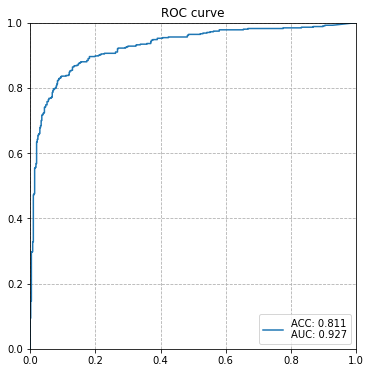

In [37]:
pred = cls_res.prediction.values
gt = label_dev.annotation.astype(bool).astype(float).values

acc = ((pred >= .5) == gt).mean()
fpr, tpr, _ = roc_curve(gt, pred)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(
    subplot_kw=dict(xlim=[0, 1], ylim=[0, 1], aspect='equal'),
    figsize=(6, 6)
)
ax.plot(fpr, tpr, label=f'ACC: {acc:.03}\nAUC: {roc_auc:.03}')
_ = ax.legend(loc="lower right")
_ = ax.set_title('ROC curve')
ax.grid(linestyle='dashed')

Visualizing the result from the test above

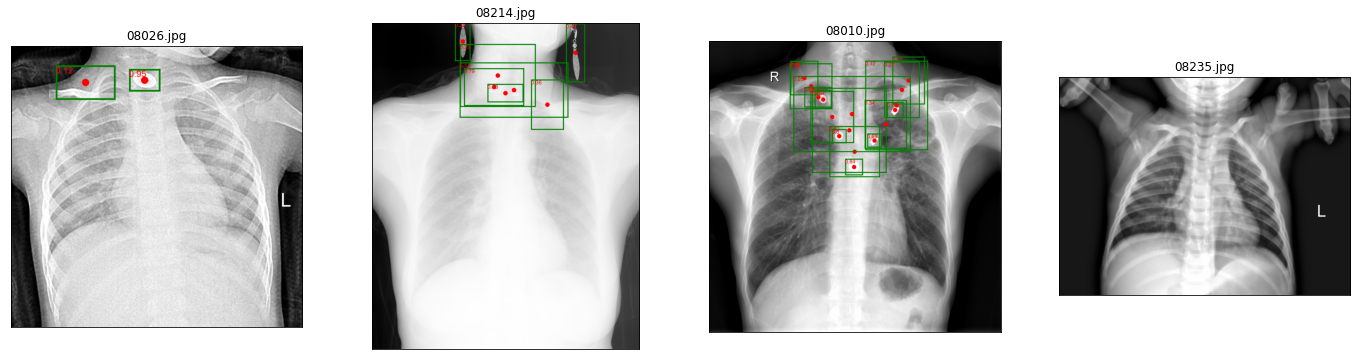

In [27]:
def draw_res(im,string,fill = (0, 0, 0, 40)):
  draw = ImageDraw.Draw(im, mode="RGBA")
  font = ImageFont.truetype('/content/drive/MyDrive/object-cxr/arial.ttf',50)
  for centers in string.split(OBJECT_SEP):
    centers = list(map(float, centers.split(ANNOTATION_SEP)))
    confidence = round(centers[0],2)
    cx,cy = centers[1:3]
    x0,x1,y0,y1 = centers[3:]    
    draw.ellipse((cx-20,cy-20,cx+20,cy+20), fill = '#ff0000')
    draw.rectangle((x0,y0,x1,y1), outline='green', width=10)
    draw.text((x0,y0),str(confidence),font=font, fill = '#ff0000')

fig, axs = plt.subplots(
    nrows=1, ncols=4, subplot_kw=dict(xticks=[], yticks=[]), figsize=(24, 6)
)
label = pd.read_csv('localization.csv', na_filter=False)
example_idxes = [25,213,9,234]
for row, ax in zip(
    label.iloc[example_idxes].itertuples(index=False), axs
):
    im = Image.open(data_dir + "dev/" + row.image_name).convert("RGB")
    if row.prediction:
        draw_res(im,row.prediction)
    
    ax.imshow(im)
    ax.set_title(f"{row.image_name}")

Calculate FROC

In [39]:
import froc
%run froc.py $data_dir"dev.csv" "localization.csv"

False positives per image:
0.125	0.25	0.5	1	2	4	8
Sensitivity:
0.599	0.715	0.806	0.853	0.879	0.879	0.879
FROC:
0.8014074595355382


<Figure size 432x288 with 0 Axes>